In [1]:
import face_recognition
from PIL import Image, ImageFilter
import glob
import os
import numpy as np
import csv
import random
from random import shuffle
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import layers, models

moods = ['cry','laugh','neutral','sad','smile']



Using TensorFlow backend.


In [3]:


def pre_processImage(mood,file):
    input_file = 'data/'+mood+'/images/'+file
    fd_image = face_recognition.load_image_file(input_file)
    face_locations = face_recognition.face_locations(fd_image)
    fc_loc_tup = face_locations[0];
    x0=fc_loc_tup[3]
    y0=fc_loc_tup[0]
    x1=fc_loc_tup[1]
    y1=fc_loc_tup[2]
#     print(face_locations)


    face_image = Image.open(input_file)
    rec = [x0,y0,x1,y1]


    #     print(rec)
    #     h=y1-y0
    #     w=x1-x0
    #     yoffset=50
    #     x0=x0-int(w/4)
    #     y0=y0-int(h/2)+yoffset
    #     x1=x1+int(w/4)
    #     y1=y1+yoffset

    #     rec=[x0,y0,x1,y1]
    #     print(rec)

    xoffset=0
    yoffset=-50
    
    #crop the image
    processed_image = face_image.crop((x0+(yoffset/2),y0+yoffset,x1-(yoffset/2),y1))
    #convert to greyscale
    processed_image = processed_image.convert('LA')
    #scale to 256x256
    processed_image = processed_image.resize((256,256), Image.ANTIALIAS)
    outputfilename = 'data/'+mood+'/processed/p_'+file
    processed_image.save(outputfilename,"png")

def pre_process():
    for mood in moods:
    #for mood in ['cry']:
        print('processing mood ->',mood)
        for filename in sorted([os.path.basename(x) for x in glob.glob('data/'+mood+'/images/*.png')]):
            print(filename)
            pre_processImage(mood,filename)

            
def convertImagesToNp():
    pix_list = []
    for idx, mood in enumerate(moods):
        print("convertImagesToCsv: ",mood)
        for filename in sorted([os.path.basename(x) for x in glob.glob('data/'+mood+'/processed/*.png')]):
            input_file = 'data/'+mood+'/processed/'+filename
            image = Image.open(input_file)
            pix_list.append(np.append(np.array(image)[:,:,0].flatten(),idx))
    
    print('shuffling pix_list')
    shuffle(pix_list)
    train_count = int(len(pix_list)*.8)
    
    print('converting ',train_count,' training rows to np array.')
    train_np = np.array(pix_list[:train_count])
    print('converting remaining rows to np array for testing.')
    test_np = np.array(pix_list[train_count:])
    np.save('train',train_np)
    np.save('test',test_np)
    print('train and test files saved.')
            

def loadTrainData():
    print('loading training data.')
    raw_data = np.load('train.npy')
    x_data = raw_data[:,:-1].reshape(raw_data.shape[0],256,256)
    y_data = raw_data[:,-1:]
    
    x_train = x_data[0:600,:]
    x_val = x_data[600:800,:]
    
    y_train = y_data[0:600,:]
    y_val = y_data[600:800,:]
    
    print (x_train.shape)
    print (y_train.shape)
    print (x_val.shape)
    print (y_val.shape)    
    return (x_train,y_train,x_val,y_val)              
                
  

## Learning

loading training data.
(600, 256, 256)
(600, 1)
(200, 256, 256)
(200, 1)
(600, 256, 256)
(600, 1)
(200, 256, 256)
(200, 1)
x_vix: 268
mood: sad


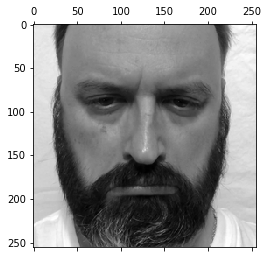

In [16]:
x_train, y_train, x_val, y_val = loadTrainData()

print (x_train.shape)
print (y_train.shape)
print (x_val.shape)
print (y_val.shape)

#visualize one of the images
x_viz = random.randint(0,600)
print('x_vix:',x_viz)
print('mood:',moods[y_train[x_viz][0]])
plt.matshow( x_train[x_viz], cmap = 'gray')
plt.show()


In [ ]:
train_images = x_train.reshape( ( 600, 256, 256, 1 ) )
train_images = train_images.astype( 'float32' ) / 255
validation_images = x_val.reshape( ( 200, 256, 256, 1 ) )
validation_images = validation_images.astype( 'float32' ) / 255

print(x_train[x_viz][255])
print(train_images[x_viz][255])
print("Before:")
print( y_train.shape )
print( y_train[1][0] )
train_labels = to_categorical( y_train )
validation_labels = to_categorical( y_val )
print("After:")
print( train_labels.shape )
print( train_labels[1] )

In [6]:
model = models.Sequential()
model.add( layers.Conv2D( 16, ( 3, 3 ), activation = 'sigmoid', input_shape = train_images[0, :, :, :].shape ) )
model.add( layers.Conv2D( 4, ( 3, 3 ), activation = 'sigmoid' ) )
model.add( layers.Flatten() )
model.add( layers.Dense( 5, activation = 'softmax' ) )
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 4)       580       
_________________________________________________________________
flatten_1 (Flatten)          (None, 254016)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1270085   
Total params: 1,270,825
Trainable params: 1,270,825
Non-trainable params: 0
_________________________________________________________________


In [ ]:

model.compile( optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )
model.fit( train_images, train_labels,validation_data=(validation_images,validation_labels), verbose=2, epochs = 10, batch_size = 10 )

In [ ]:

validation_loss, validation_acc = model.evaluate( validation_images, validation_labels )
print( 'validation_acc:', validation_acc )